Linear regression in depth
==========================

*Fraida Fund*

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

# for 3d interactive plots
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Data generated by a linear function
-----------------------------------

Suppose we have a process that generates data as

$$y_i = w_0 + w_1 x_{i,1} + \ldots + w_d x_{i,d} + \epsilon_i $$

where $\epsilon_i \sim N(0, \sigma^2)$.

Note: in this example, we use a “stochastic error” term. This is not to
be confused with a residual term which can include systematic,
non-random error.

-   stochastic error: difference between observed value and “true”
    value. These random errors are independent, not systematic, and
    cannot be “learned” by any machine learning model.
-   residual: difference between observed value and estimated value.
    These errors are typical *not* independent, and they can be
    systematic.

Here’s a function to generate this kind of data

In [ ]:
def generate_linear_regression_data(n=100, d=1, coef=[5], intercept=1, sigma=0):
  x = np.random.randn(n,d)
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  return x, y

and some default values we’ll use:

In [ ]:
n_samples = 100
coef = [5]
intercept = 1

Simple linear regression
------------------------

### Generate some data

In [ ]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=1, coef=coef, intercept=intercept)
x_test,  y_test  = generate_linear_regression_data(n=50, d=1, coef=coef, intercept=intercept)

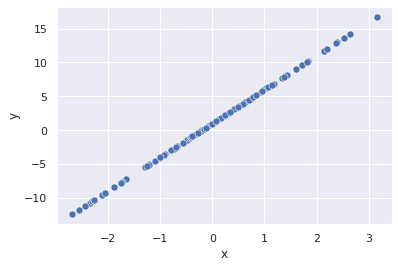

In [ ]:
sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
plt.xlabel('x');
plt.ylabel('y');

### Fit a linear regression

In [ ]:
reg_simple = LinearRegression().fit(x_train, y_train)
print("Intercept: " , reg_simple.intercept_)
print("Coefficient list: ", reg_simple.coef_)

Intercept:  0.9999999999999998
Coefficient list:  [5.]


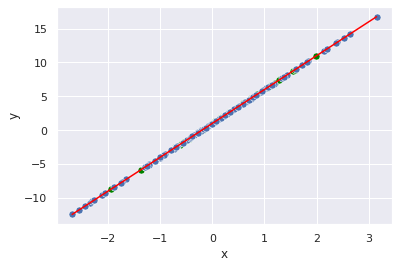

In [ ]:
x_line = [np.min(x_train), np.max(x_train)]
y_line = x_line*reg_simple.coef_ + reg_simple.intercept_
sns.scatterplot(x=x_test.squeeze(), y=y_test, s=50, color='green');
sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
sns.lineplot(x=x_line, y=y_line, color='red');
plt.xlabel('x');
plt.ylabel('y');

In [ ]:
# Note: other ways to do the same thing...
# first, add a ones column to design matrix
x_tilde = np.hstack((np.ones((n_samples, 1)), x_train))

# using matrix operations to find w = (X^T X)^{-1} X^T y
print( (np.linalg.inv((x_tilde.T.dot(x_tilde))).dot(x_tilde.T)).dot(y_train) )

# using solve on normal equations: X^T X w = X^T y
# solve only works on matrix that is square and of full-rank
# see https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
print( np.linalg.solve(x_tilde.T.dot(x_tilde), x_tilde.T.dot(y_train)) )

# using the lstsq solver 
# problem may be under-, well-, or over-determined
# see https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
print( np.linalg.lstsq(x_tilde,y_train,rcond=0)[0] ) 

[1. 5.]
[1. 5.]
[1. 5.]


### The mean-removed equivalent

Quick digression - what if we don’t want to bother with intercept?

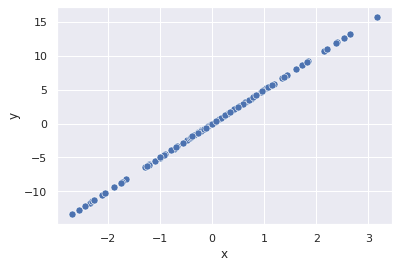

In [ ]:
x_train_mr = x_train - np.mean(x_train)
y_train_mr = y_train - np.mean(y_train)
sns.scatterplot(x=x_train_mr.squeeze(), y=y_train_mr, s=50);
plt.xlabel('x');
plt.ylabel('y');

Note that now the data is mean removed - zero mean in every dimension.
(Removing the mean is also called *centering* the data.)

This time, the fitted linear regression has 0 intercept:

In [ ]:
reg_mr = LinearRegression().fit(x_train_mr, y_train_mr)
print("Intercept: " , reg_mr.intercept_)
print("Coefficient list: ", reg_mr.coef_)

Intercept:  7.549516567451064e-17
Coefficient list:  [5.]


### Predict some new points

OK, now we can predict some new points:

In [ ]:
y_test_hat = reg_simple.intercept_ + np.dot(x_test,reg_simple.coef_)

In [ ]:
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_simple.coef_ + reg_simple.intercept_

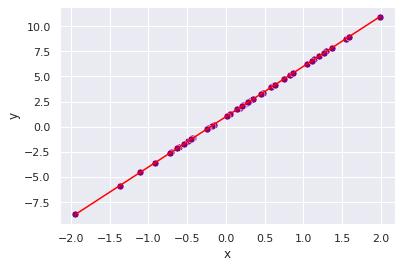

In [ ]:
sns.lineplot(x=x_line, y=y_line, color='red');
sns.scatterplot(x=x_test.squeeze(), y=y_test_hat, s=50, color='purple');
plt.xlabel('x');
plt.ylabel('y');

### Compute MSE

To evaluate the model, we will compute the MSE on the test data (not the
data used to find the parameters).

$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - (w_0 + w_1 x_i)) ^2$$

Use $\hat{y}_i = w_0 + w_1 x_i$, then

$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i) ^2$$

In [ ]:
y_test_hat = reg_simple.intercept_ + np.dot(x_test,reg_simple.coef_)
mse_simple = 1.0/(len(y_test)) * np.sum((y_test - y_test_hat)**2)
mse_simple

3.747089299799806e-32

In [ ]:
# another way to do the same thing using sklearn
y_test_hat = reg_simple.predict(x_test)
metrics.mean_squared_error(y_test, y_test_hat)

3.747089299799806e-32

### Visualize MSE for different coefficients

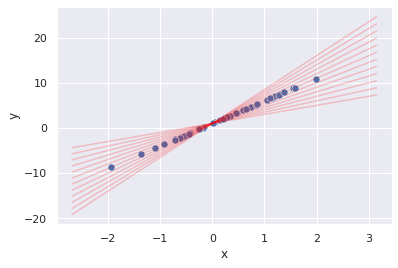

In [ ]:
p = sns.scatterplot(x=x_test.squeeze(), y=y_test_hat, s=50);
p = plt.xlabel('x')
p = plt.ylabel('y')

coefs = np.arange(2, 8, 0.5)
mses = np.zeros(len(coefs))

for idx, c in enumerate(coefs):
  y_test_hat_c = (reg_simple.intercept_ + np.dot(x_test,c)).squeeze()
  mses[idx] =  1.0/(len(y_test_hat_c)) * np.sum((y_test - y_test_hat_c)**2)
  x_line = [np.min(x_train), np.max(x_train)]
  y_line = [x_line[0]*c + reg_simple.intercept_, x_line[1]*c + intercept]
  p = sns.lineplot(x=x_line, y=y_line, color='red', alpha=0.2);

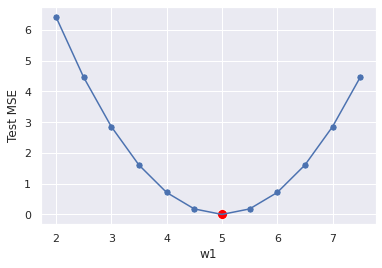

In [ ]:
sns.lineplot(x=coefs, y=mses);
sns.scatterplot(x=coefs, y=mses, s=50);
sns.scatterplot(x=reg_simple.coef_, y=mse_simple, color='red', s=100);
p = plt.xlabel('w1');
p = plt.ylabel('Test MSE');

### Variance, explained variance, R2

Quick reminder:

Mean of $x$ and $y$:

$$\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i, \quad \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$$

Sample variance of $x$ and $y$:

$$\sigma_x^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x}) ^2, \quad \sigma_y^2 = \frac{1}{n} \sum_{i=1}^n (y_i - \bar{y}) ^2$$

Sample covariance of $x$ and $y$:

$$\sigma_{xy} = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})$$

In [ ]:
var_y = 1.0/len(y_test) * np.sum((y_test - np.mean(y_test))**2)
var_y

16.412174554819405

In [ ]:
mean_y = np.mean(y_test)
mean_y

2.2053254086776577

The variance of $y$ is the mean sum of the squares of the distances from
each $y_i$ to $\bar{y}$. These distances are illustrated here:

-   the horizontal line shows $\bar{y}$
-   each vertical line is a distance from a $y_i$ to $\bar{y}$

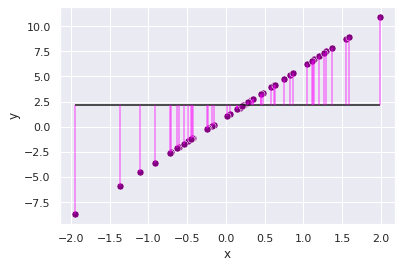

In [ ]:
plt.hlines(y=mean_y, xmin=np.min(x_test), xmax=np.max(x_test));
plt.vlines(x_test, ymin=mean_y, ymax=y_test, alpha=0.5, color='magenta');
sns.scatterplot(x=x_test.squeeze(), y=y_test, color='purple', s=50);
plt.xlabel('x');
plt.ylabel('y');

Now let’s look at a similar kind of plot, but with distances to the
regression line instead of the to mean line:

-   In the previous plot, each vertical line was a $y_i - \bar{y}$
-   In the following plot, each vertical line is a $y_i - \hat{y}_i$

(where $\hat{y}_i$ is the prediction of the linear regression for a
given sample $i$)

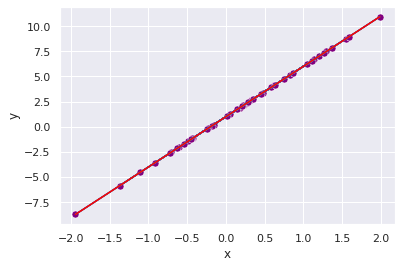

In [ ]:
plt.plot(x_test, y_test_hat);
plt.vlines(x_test, ymin=y_test, ymax=y_test_hat, color='magenta', alpha=0.5);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color='purple', s=50);
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_simple.coef_ + reg_simple.intercept_
sns.lineplot(x=x_line, y=y_line, color='red');
plt.xlabel('x');
plt.ylabel('y');

These two plots together show how well the variance of $y$ is
“explained” by the linear regression model:

-   The total variance of $y$ is shown in the first plot, where each
    vertical line is $y_i - \bar{y}$
-   The *unexplained* variance of $y$ is shown in the second plot, where
    each vertical line is the error of the model, $y_i - \hat{y}_i$

In this example, *all* of the variance of $y$ is “explained” by the
linear regression.

MSE for this example is 0, R2 is 1.

Simple linear regression with noise
-----------------------------------

### Generate some data

In [ ]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=1, coef=coef, intercept=intercept, sigma=2)
x_test,  y_test =  generate_linear_regression_data(n=50, d=1, coef=coef, intercept=intercept, sigma=2)

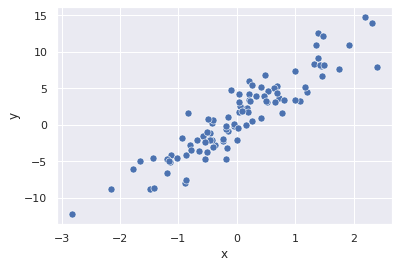

In [ ]:
sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
plt.xlabel('x');
plt.ylabel('y');

### Fit a linear regression

In [ ]:
reg_noisy = LinearRegression().fit(x_train, y_train)
print("Coefficient list: ", reg_noisy.coef_)
print("Intercept: " , reg_noisy.intercept_)

Coefficient list:  [5.0688472]
Intercept:  0.9155316558148738


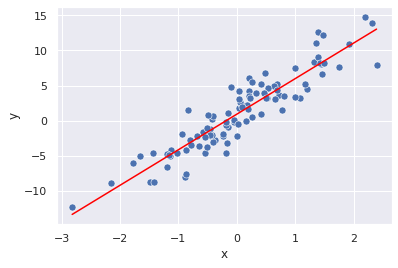

In [ ]:
x_line = [np.min(x_train), np.max(x_train)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_

sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
sns.lineplot(x=x_line, y=y_line, color='red');
plt.xlabel('x');
plt.ylabel('y');


### Predict some new points

In [ ]:
y_test_hat = reg_noisy.intercept_ + np.dot(x_test,reg_noisy.coef_)

In [ ]:
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_

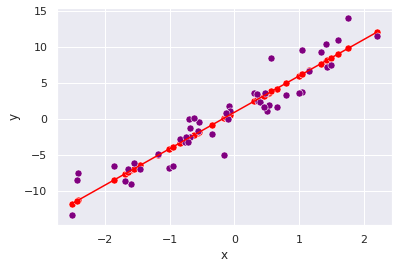

In [ ]:
sns.lineplot(x=x_line, y=y_line, color='red');
sns.scatterplot(x=x_test.squeeze(), y=y_test_hat, color='red', s=50);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color='purple', s=50);
plt.xlabel('x');
plt.ylabel('y');


### Compute MSE

In [ ]:
y_test_hat = reg_noisy.intercept_ + np.dot(x_test,reg_noisy.coef_)
mse_noisy = 1.0/(len(y_test)) * np.sum((y_test - y_test_hat)**2)
mse_noisy

3.9253572901556892

The MSE is higher than before!

Does this mean our estimate of $w_0$ and $w_1$ is not optimal?

Since we generated the data, we know the “true” coefficient value and we
can see how much the MSE would be with the true coefficient values.

In [ ]:
y_test_perfect_coef = intercept + np.dot(x_test,coef)

mse_perfect_coef = 1.0/(len(y_test_perfect_coef)) * np.sum((y_test_perfect_coef - y_test)**2)
mse_perfect_coef

3.9146327929217177

Important: I thought we selected the coefficients that minimize MSE! But
sometimes our linear regression doesn’t select the “true” coefficients?

In [ ]:
y_train_hat = reg_noisy.intercept_ + np.dot(x_train,reg_noisy.coef_)
mse_train_est = 1.0/(len(y_train)) * np.sum((y_train - y_train_hat)**2)
mse_train_est

4.229258027596469

In [ ]:
y_train_perfect_coef = intercept + np.dot(x_train,coef)
mse_train_perfect = 1.0/(len(y_train_perfect_coef)) * np.sum((y_train_perfect_coef - y_train)**2)
mse_train_perfect

4.240467177974649

The “correct” coefficients had slightly higher MSE on the training set
than the fitted coefficients. We fit parameters so that they are optimal
on the *training* set, then we use the test set to understand how the
model will generalize to new, unseen data.

We saw that part of the MSE is due to noise in the data, and part is due
to error in the parameter estimates.

Soon - we will formalize this discussion of different sources of error:

-   Error in parameter estimates
-   “Noise” - any variation in data that is not a function of the $X$
    that we use as input to the model
-   Other error - model (hypothesis class) not a good choice for the
    data, for example

### Visualize MSE for different coefficients

In [ ]:
coefs = np.arange(4.5, 5.5, 0.1)
mses_test = np.zeros(len(coefs))
mses_train = np.zeros(len(coefs))

for idx, c in enumerate(coefs):
  y_test_hat_c = (reg_noisy.intercept_ + np.dot(x_test,c)).squeeze()
  mses_test[idx] =  1.0/(len(y_test_hat_c)) * np.sum((y_test - y_test_hat_c)**2)
  y_train_hat_c = (reg_noisy.intercept_ + np.dot(x_train,c)).squeeze()
  mses_train[idx] =  1.0/(len(y_train_hat_c)) * np.sum((y_train - y_train_hat_c)**2)

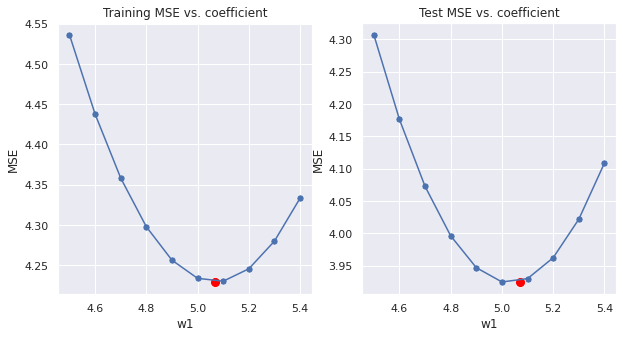

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.lineplot(x=coefs, y=mses_train)
sns.scatterplot(x=coefs, y=mses_train, s=50);
sns.scatterplot(x=reg_noisy.coef_, y=mse_train_est, color='red', s=100);
plt.title("Training MSE vs. coefficient");
plt.xlabel('w1');
plt.ylabel('MSE');

plt.subplot(1,2,2)
sns.lineplot(x=coefs, y=mses_test)
sns.scatterplot(x=coefs, y=mses_test, s=50);
sns.scatterplot(x=reg_noisy.coef_, y=mse_noisy, color='red', s=100);
plt.title("Test MSE vs. coefficient");
plt.xlabel('w1');
plt.ylabel('MSE');

In the plot on the left (for training MSE), the red dot (our coefficient
estimate) should always have minimum MSE, because we select parameters
to minimize MSE on the training set.

In the plot on the right (for test MSE), the red dot might not have the
minimum MSE, because the best coefficient on the training set might not
be the best coefficient on the test set. This gives us some idea of how
our model will generalize to new, unseen data. We may suspect that if
the coefficient estimate is not perfect for *this* test data, it might
have some error on other new, unseen data, too.

If you re-run this notebook many times, you’ll get a new random sample
of training and test data each time. Sometimes, the “true” coefficients
may have smaller MSE on the test set than the estimated coefficients. On
other runs, the estimated coefficients might have smaller MSE on the
test set.

### Variance, explained variance, R2

In [ ]:
var_y = 1.0/len(y_test) * np.sum((y_test - np.mean(y_test))**2)
var_y

37.97690868932788

In [ ]:
mean_y = np.mean(y_test)
mean_y

0.30420518693627807

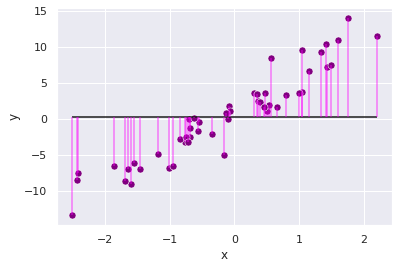

In [ ]:
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_
plt.hlines(mean_y, xmin=np.min(x_test), xmax=np.max(x_test));
plt.vlines(x_test, ymin=mean_y, ymax=y_test, color='magenta', alpha=0.5);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color='purple', s=50);
plt.xlabel('x');
plt.ylabel('y');

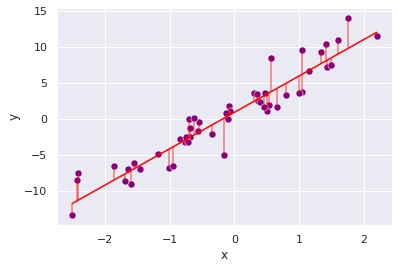

In [ ]:
plt.vlines(x_test, ymin=y_test, ymax=y_test_hat, color='red', alpha=0.5);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color='purple', s=50);
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_
sns.lineplot(x=x_line, y=y_line, color='red');
plt.xlabel('x');
plt.ylabel('y');

Remember:

-   The total variance of $y$ is shown in the first plot, where each
    vertical line is $y_i - \bar{y}$
-   The *unexplained* variance of $y$ is shown in the second plot, where
    each vertical line is the error of the model, $y_i - \hat{y}_i$

In the next plot, we’ll combine them to get some intuition regarding the
*fraction of unexplained variance*. The dark maroon part of each
vertical bar is the *unexplained* part, while the red part is
*explained* by the linear regression.

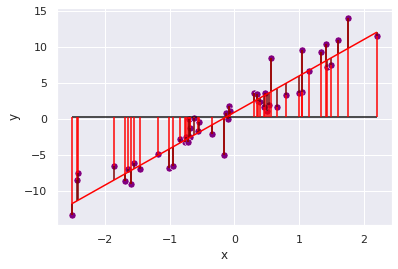

In [ ]:

x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_

plt.hlines(mean_y, xmin=np.min(x_test), xmax=np.max(x_test));
plt.vlines(x_test, ymin=mean_y, ymax=y_test, color='red');
plt.vlines(x_test, ymin=y_test, ymax=y_test_hat, color='maroon');
sns.scatterplot(x=x_test.squeeze(), y=y_test, color='purple', s=50);
sns.lineplot(x=x_line, y=y_line, color='red');
plt.xlabel('x');
plt.ylabel('y');

**Fraction of variance unexplained** is the ratio of the sum of squared
distances from data to the regression line (sum of squared vertical
distances in second plot), to the sum of squared distanced from data to
the mean (sum of squared vertical distances in first plot):

$$\frac{MSE}{Var(y)} = \frac{Var(y-\hat{y})}{Var(y)} = \frac{\sum_{i=1}^n(y_i-\hat y_i)^2}{\sum_{i=1}^n(y_i - \bar{y})^2}$$

Alternative interpretation: imagine we would develop a very simple ML
model, in which we always predict $\hat{y}_i = \bar{y}_i$. Then, we use
this model as a basis for comparison for other, more sophisticated
models. The ratio above is the ratio of error of the regression model,
to the error of a “prediction by mean” model.

-   If this quantity is less than 1, our model is better than
    “prediction by mean”
-   If this quantity is greater than 1, our model is worse than
    “prediction by mean”

In [ ]:
fvu = mse_noisy/var_y
fvu

0.10336168544594515

In [ ]:
r2 = 1 - fvu
r2

0.8966383145540548

In [ ]:
# another way to do the same thing...
metrics.r2_score(y_test, y_test_hat)

0.8966383145540548

What does a negative R2 mean, in terms of a comparison to “prediction by
mean”?

Residual analysis
-----------------

In [ ]:
df = sns.load_dataset("anscombe")
df.groupby('dataset').agg({'x': ['count','mean', 'std'], 'y': ['count','mean', 'std']})

x                    y                    
        count mean       std count      mean       std
dataset                                               
I          11  9.0  3.316625    11  7.500909  2.031568
II         11  9.0  3.316625    11  7.500909  2.031657
III        11  9.0  3.316625    11  7.500000  2.030424
IV         11  9.0  3.316625    11  7.500909  2.030579

In [ ]:
data_i   = df[df['dataset'].eq('I')]
data_ii  = df[df['dataset'].eq('II')]
data_iii = df[df['dataset'].eq('III')]
data_iv  = df[df['dataset'].eq('IV')]

In [ ]:
reg_i   = LinearRegression().fit(data_i[['x']],   data_i['y'])
reg_ii  = LinearRegression().fit(data_ii[['x']],  data_ii['y'])
reg_iii = LinearRegression().fit(data_iii[['x']], data_iii['y'])
reg_iv  = LinearRegression().fit(data_iv[['x']],  data_iv['y'])

In [ ]:
print("Dataset I:   ",   reg_i.coef_,   reg_i.intercept_)
print("Dataset II:  ",  reg_ii.coef_,  reg_ii.intercept_)
print("Dataset III: ", reg_iii.coef_, reg_iii.intercept_)
print("Dataset IV:  ",  reg_iv.coef_,  reg_iv.intercept_)

Dataset I:    [0.50009091] 3.0000909090909094
Dataset II:   [0.5] 3.00090909090909
Dataset III:  [0.49972727] 3.002454545454545
Dataset IV:   [0.49990909] 3.0017272727272726


In [ ]:
print("Dataset I:   ", metrics.r2_score(data_i['y'],  reg_i.predict(data_i[['x']])))
print("Dataset II:  ", metrics.r2_score(data_ii['y'], reg_ii.predict(data_ii[['x']])))
print("Dataset III: ", metrics.r2_score(data_iii['y'],reg_iii.predict(data_iii[['x']])))
print("Dataset IV:  ", metrics.r2_score(data_iv['y'], reg_iv.predict(data_iv[['x']])))

Dataset I:    0.6665424595087748
Dataset II:   0.6662420337274844
Dataset III:  0.6663240410665592
Dataset IV:   0.6667072568984653


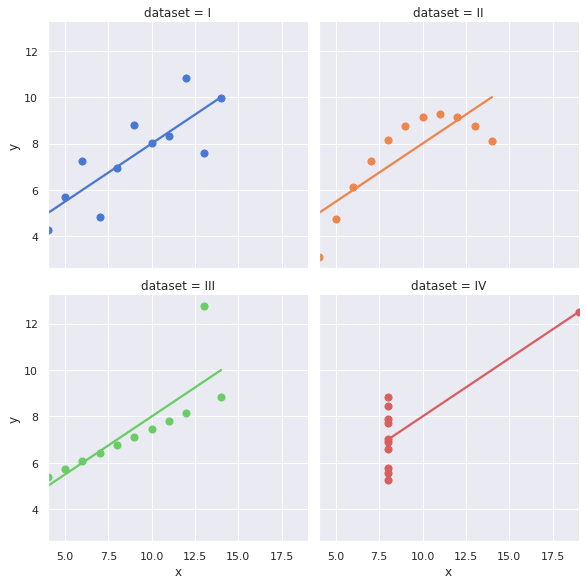

In [ ]:
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", 
           data=df, col_wrap=2, ci=None, palette="muted", height=4, 
           scatter_kws={"s": 50, "alpha": 1});

Does the linear model fit well?

-   the linear model is a good fit for Dataset I
-   Dataset II is clearly non-linear
-   Dataset III has an outlier
-   Dataset IV has a high leverage point

Easy to identify problems in 1D - what about in higher D?

-   Plot $\hat{y}$ against $y$
-   Plot residuals against $\hat{y}$
-   Plot residuals against each $x$ (including any $x$ not in the model)
-   Plot residuals against time (for time series data)

What should each of these plots look like if the regression is “good”?

In [ ]:
data_i   = data_i.assign(   yhat = reg_i.predict(  data_i[['x']]) )
data_ii  = data_ii.assign(  yhat = reg_ii.predict( data_ii[['x']]) )
data_iii = data_iii.assign( yhat = reg_iii.predict( data_iii[['x']]) )
data_iv  = data_iv.assign(  yhat = reg_iv.predict(  data_iv[['x']]) )

data_i   = data_i.assign(   residual = data_i['y'] - data_i['yhat'] )
data_ii  = data_ii.assign(  residual = data_ii['y'] - data_ii['yhat'] )
data_iii = data_iii.assign( residual = data_iii['y'] - data_iii['yhat'] )
data_iv  = data_iv.assign(  residual = data_iv['y'] - data_iv['yhat'] )

data_all = pd.concat([data_i, data_ii, data_iii, data_iv])
data_all.head()

,dataset,x,y,yhat,residual
0,I,10.0,8.04,8.001000,0.039000
1,I,8.0,6.95,7.000818,-0.050818
2,I,13.0,7.58,9.501273,-1.921273
3,I,9.0,8.81,7.500909,1.309091
4,I,11.0,8.33,8.501091,-0.171091


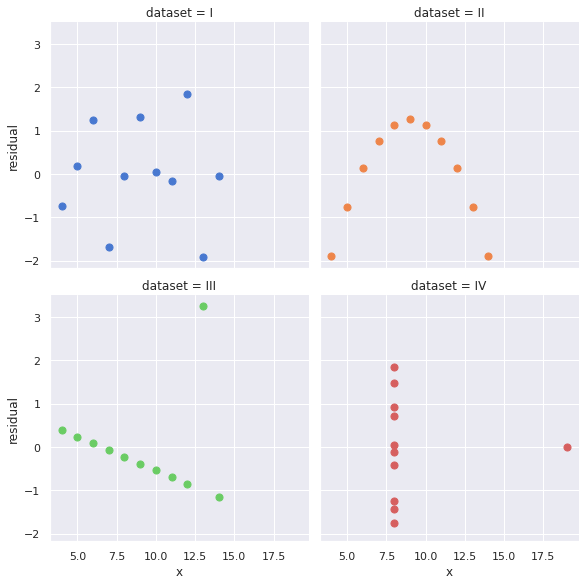

In [ ]:
sns.lmplot(x="x", y="residual", col="dataset", hue="dataset", 
           data=data_all, col_wrap=2, ci=None, palette="muted", height=4, 
           scatter_kws={"s": 50, "alpha": 1}, fit_reg=False);

Multiple linear regression
--------------------------

### Generate some data

In [ ]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=2, coef=[5,5], intercept=intercept)
x_test,  y_test  = generate_linear_regression_data(n=50, d=2, coef=[5,5], intercept=intercept)


In [ ]:
x_train.shape

(100, 2)

In [ ]:
y_train.shape

(100,)

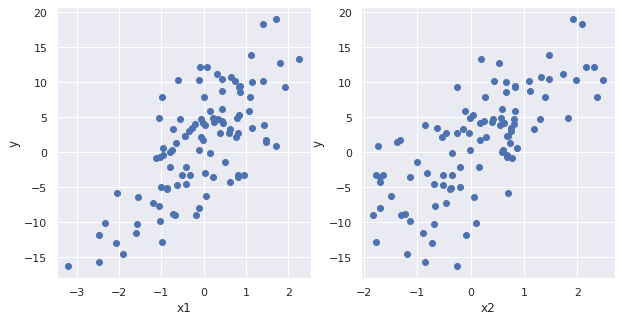

In [ ]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  y_train);
plt.xlabel("x1");
plt.ylabel("y");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  y_train);
plt.xlabel("x2");
plt.ylabel("y");

Recall that there is no stochastic noise in this data - so it fits a
linear model perfectly. But it’s more difficult to see that linear
relationship in higher dimensions.

### Fit a linear regression

In [ ]:
reg_multi = LinearRegression().fit(x_train, y_train)
print("Coefficient list: ", reg_multi.coef_)
print("Intercept: " , reg_multi.intercept_)

Coefficient list:  [5. 5.]
Intercept:  1.0


### Plot hyperplane

In [ ]:
def plot_3D(elev=20, azim=-20, X=x_train, y=y_train):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')


    X1 = np.arange(-4, 4, 0.2)
    X2 = np.arange(-4, 4, 0.2)
    X1, X2 = np.meshgrid(X1, X2)
    Z = X1*reg_multi.coef_[0] + X2*reg_multi.coef_[1]

    # Plot the surface.
    ax.plot_surface(X1, X2, Z, alpha=0.1, color='gray',
                          linewidth=0, antialiased=False)
    ax.scatter3D(X[:, 0], X[:, 1], y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')

interact(plot_3D, elev=np.arange(-90,90,10), azim=np.arange(-90,90,10),
         X=fixed(x_train), y=fixed(y_train));

interactive(children=(Dropdown(description='elev', index=11, options=(-90, -80, -70, -60, -50, -40, -30, -20, …

### MSE contour

In [ ]:
coefs = np.arange(3.0, 7.0, 0.05)
mses_train = np.zeros((len(coefs), len(coefs)))

for idx_1, c_1 in enumerate(coefs):
  for idx_2, c_2 in enumerate(coefs):
    y_train_hat_c = (reg_multi.intercept_ + np.dot(x_train,[c_1, c_2])).squeeze()
    mses_train[idx_1,idx_2] =  1.0/(len(y_train_hat_c)) * np.sum((y_train - y_train_hat_c)**2)

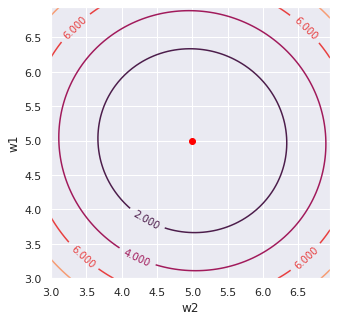

In [ ]:
plt.figure(figsize=(5,5));
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.scatter(x=reg_multi.coef_[1], y=reg_multi.coef_[0], c='red')
p = plt.contour(X1, X2, mses_train, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w2');
plt.ylabel('w1');

In [ ]:
coefs = np.arange(3.0, 7.0, 0.05)
mses_test = np.zeros((len(coefs), len(coefs)))

for idx_1, c_1 in enumerate(coefs):
  for idx_2, c_2 in enumerate(coefs):
    y_test_hat_c = (reg_multi.intercept_ + np.dot(x_test,[c_1, c_2])).squeeze()
    mses_test[idx_1,idx_2] =  1.0/(len(y_test_hat_c)) * np.sum((y_test - y_test_hat_c)**2)

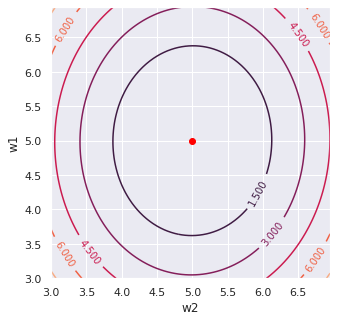

In [ ]:
plt.figure(figsize=(5,5));
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.scatter(x=reg_multi.coef_[1], y=reg_multi.coef_[0], c='red')
p = plt.contour(X1, X2, mses_test, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w2');
plt.ylabel('w1');

Multiple linear regression with noise
-------------------------------------

### Generate some data

In [ ]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=2, coef=[5,5], intercept=intercept, sigma=5)
x_test,  y_test  = generate_linear_regression_data(n=50, d=2, coef=[5,5], intercept=intercept, sigma=5)

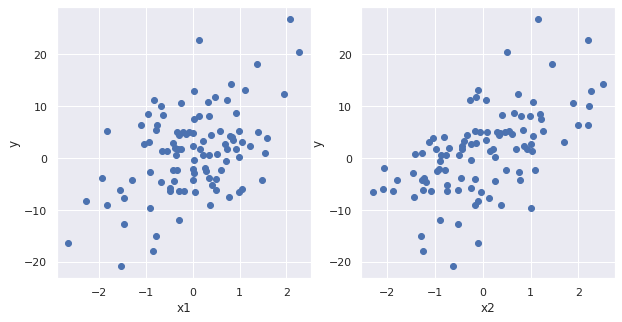

In [ ]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  y_train);
plt.xlabel("x1");
plt.ylabel("y");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  y_train);
plt.xlabel("x2");
plt.ylabel("y");

### Fit a linear regression

In [ ]:
reg_multi_noisy = LinearRegression().fit(x_train, y_train)
print("Coefficient list: ", reg_multi_noisy.coef_)
print("Intercept: " , reg_multi_noisy.intercept_)

Coefficient list:  [5.03928238 5.16151065]
Intercept:  1.169268478733987


### Plot hyperplane

In [ ]:
def plot_3D(elev=20, azim=-20, X=x_train, y=y_train):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')


    X1 = np.arange(-4, 4, 0.2)
    X2 = np.arange(-4, 4, 0.2)
    X1, X2 = np.meshgrid(X1, X2)
    Z = X1*reg_multi_noisy.coef_[0] + X2*reg_multi_noisy.coef_[1]

    # Plot the surface.
    ax.plot_surface(X1, X2, Z, alpha=0.1, color='gray',
                          linewidth=0, antialiased=False)
    ax.scatter3D(X[:, 0], X[:, 1], y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')

interact(plot_3D, elev=np.arange(-90,90,10), azim=np.arange(-90,90,10),
         X=fixed(x_train), y=fixed(y_train));

interactive(children=(Dropdown(description='elev', index=11, options=(-90, -80, -70, -60, -50, -40, -30, -20, …

### MSE contour

In [ ]:
coefs = np.arange(3.0, 7.0, 0.05)
mses_train = np.zeros((len(coefs), len(coefs)))

for idx_1, c_1 in enumerate(coefs):
  for idx_2, c_2 in enumerate(coefs):
    y_train_hat_c = (reg_multi_noisy.intercept_ + np.dot(x_train,[c_1, c_2])).squeeze()
    mses_train[idx_1,idx_2] =  1.0/(len(y_train_hat_c)) * np.sum((y_train - y_train_hat_c)**2)

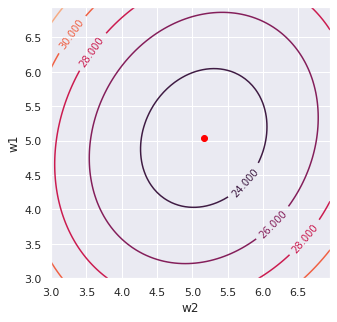

In [ ]:
plt.figure(figsize=(5,5));
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.scatter(x=reg_multi_noisy.coef_[1], y=reg_multi_noisy.coef_[0], c='red')
p = plt.contour(X1, X2, mses_train, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w2');
plt.ylabel('w1');

In [ ]:
coefs = np.arange(3.0, 7.0, 0.05)
mses_test = np.zeros((len(coefs), len(coefs)))

for idx_1, c_1 in enumerate(coefs):
  for idx_2, c_2 in enumerate(coefs):
    y_test_hat_c = (reg_multi_noisy.intercept_ + np.dot(x_test,[c_1, c_2])).squeeze()
    mses_test[idx_1,idx_2] =  1.0/(len(y_test_hat_c)) * np.sum((y_test - y_test_hat_c)**2)

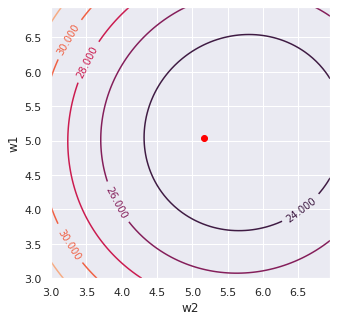

In [ ]:
plt.figure(figsize=(5,5));
X1, X2 = np.meshgrid(coefs, coefs)
p = plt.scatter(x=reg_multi_noisy.coef_[1], y=reg_multi_noisy.coef_[0], c='red')
p = plt.contour(X1, X2, mses_test, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w2');
plt.ylabel('w1');

Linear basis function regression
--------------------------------

The assumptions of the linear model (that the target variable can be
predicted as a linear combination of the features) can be restrictive.
We can capture more complicated relationships using linear basis
function regression.

### Generate some data

In [ ]:
import itertools

def generate_linear_basis_data(n=100, d=2, coef=[1,1,0.5,0.5,1], intercept=1, sigma=0):
  x = np.random.randn(n,d)
  x = np.column_stack((x, x**2 ))
  for pair in list(itertools.combinations(range(d), 2)):
    x = np.column_stack((x, x[:,pair[0]]*x[:,pair[1]]))
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  return x[:,:d], y

In [ ]:
x_train, y_train = generate_linear_basis_data(sigma=0.2)
x_test,  y_test  = generate_linear_basis_data(n=50, sigma=0.2)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(100, 2)
(100,)


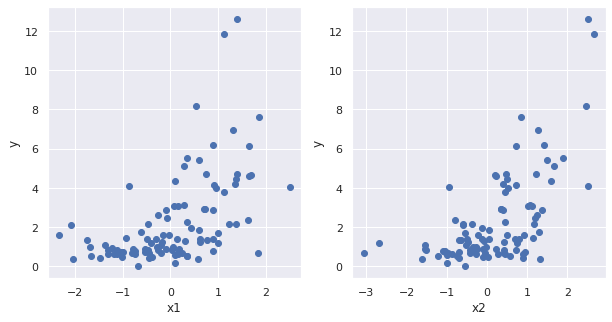

In [ ]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  y_train);
plt.xlabel("x1");
plt.ylabel("y");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  y_train);
plt.xlabel("x2");
plt.ylabel("y");

### Fit a linear regression

In [ ]:
reg_lbf = LinearRegression().fit(x_train, y_train)
print("Intercept: " , reg_lbf.intercept_)
print("Coefficient list: ", reg_lbf.coef_)

Intercept:  1.9608514493799205
Coefficient list:  [1.27523138 1.41588296]


### Compute MSE and R2

In [ ]:
y_train_hat = reg_lbf.predict(x_train)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_hat))

Training MSE:  1.5725275434026846
Training R2:   0.6979146276839245


### Residual analysis

In [ ]:
residual_train = y_train - y_train_hat

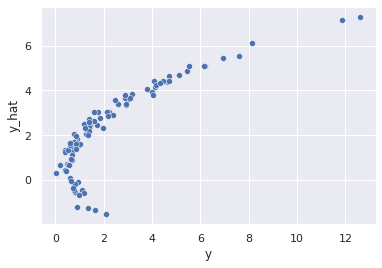

In [ ]:
_ = sns.scatterplot(x=y_train, y=y_train_hat)
_ = plt.xlabel('y')
_ = plt.ylabel('y_hat')

Is the error random? Or does it look systematic?

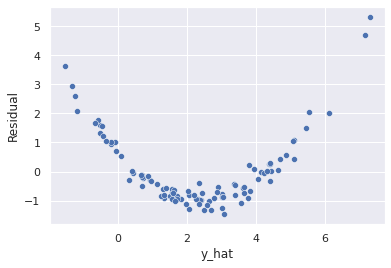

In [ ]:
_ = sns.scatterplot(x=y_train_hat, y=residual_train)
_ = plt.xlabel('y_hat')
_ = plt.ylabel('Residual')

Since there is clearly some non-linearity, we can try to fit a model to
a non-linear transformation of the features.

In [ ]:
x_train_trans = np.column_stack((x_train, x_train**2))

reg_lbf_trans = LinearRegression().fit(x_train_trans, y_train)
print("Intercept: " , reg_lbf_trans.intercept_)
print("Coefficient list: ", reg_lbf_trans.coef_)

y_train_trans_hat = reg_lbf_trans.predict(x_train_trans)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_trans_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_trans_hat))

residual_train_trans = y_train - y_train_trans_hat

Intercept:  1.165947485088587
Coefficient list:  [1.14302733 1.38548127 0.43813203 0.34963541]
Training MSE:  0.920700651068172
Training R2:   0.8231317472711766


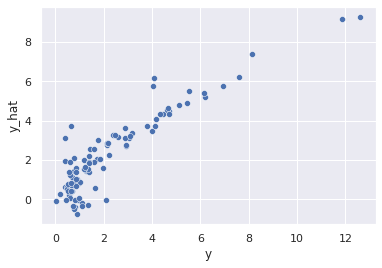

In [ ]:
_ = sns.scatterplot(x=y_train, y=y_train_trans_hat)
_ = plt.xlabel('y')
_ = plt.ylabel('y_hat')

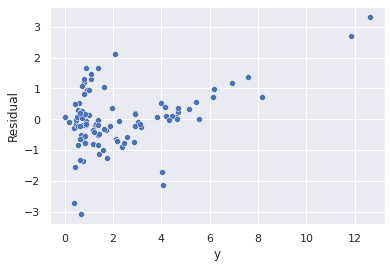

In [ ]:
_ = sns.scatterplot(x=y_train, y=residual_train_trans)
_ = plt.xlabel('y')
_ = plt.ylabel('Residual')

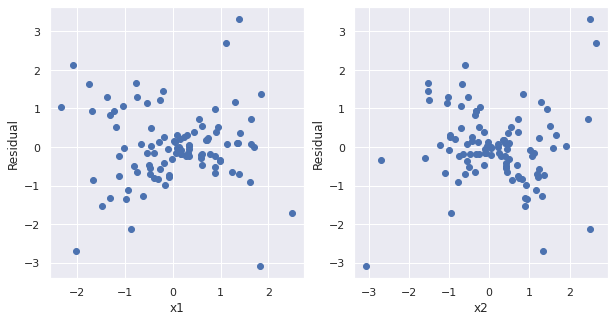

In [ ]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  residual_train_trans);
plt.xlabel("x1");
plt.ylabel("Residual");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  residual_train_trans);
plt.xlabel("x2");
plt.ylabel("Residual");

In [ ]:
x_train_inter = np.column_stack((x_train_trans, x_train[:,0]*x_train[:,1]))

reg_lbf_inter = LinearRegression().fit(x_train_inter, y_train)
print("Intercept: " , reg_lbf_inter.intercept_)
print("Coefficient list: ", reg_lbf_inter.coef_)

y_train_inter_hat = reg_lbf_inter.predict(x_train_inter)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_inter_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_inter_hat))

residual_train_inter = y_train - y_train_inter_hat

Intercept:  1.0196142325058577
Coefficient list:  [1.03436612 0.97989403 0.51028183 0.49658506 0.98684925]
Training MSE:  0.03583759120580297
Training R2:   0.9931155342062304


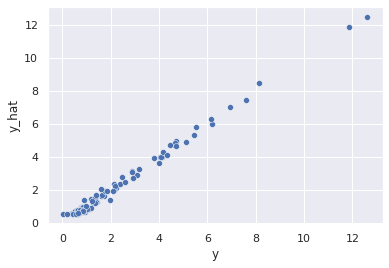

In [ ]:
_ = sns.scatterplot(x=y_train, y=y_train_inter_hat)
_ = plt.xlabel('y')
_ = plt.ylabel('y_hat')

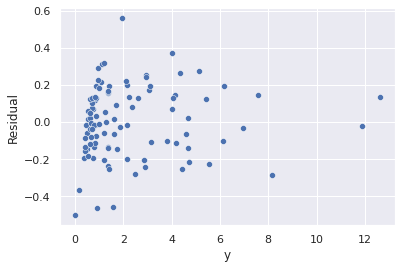

In [ ]:
_ = sns.scatterplot(x=y_train, y=residual_train_inter)
_ = plt.xlabel('y')
_ = plt.ylabel('Residual')

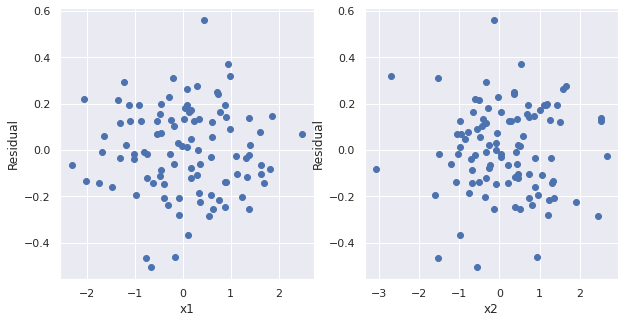

In [ ]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  residual_train_inter);
plt.xlabel("x1");
plt.ylabel("Residual");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  residual_train_inter);
plt.xlabel("x2");
plt.ylabel("Residual");

### Evaluate on test set

In [ ]:
y_train_hat = reg_lbf_inter.predict(x_train_inter)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_hat))

Training MSE:  0.03583759120580297
Training R2:   0.9931155342062304


In [ ]:
x_test_inter = np.column_stack((x_test, x_test**2))
x_test_inter = np.column_stack((x_test_inter, x_test[:,0]*x_test[:,1]))

y_test_hat = reg_lbf_inter.predict(x_test_inter)
print("Test MSE: ", metrics.mean_squared_error(y_test, y_test_hat))
print("Test R2:  ", metrics.r2_score(y_test, y_test_hat))

Test MSE:  0.03853621280947777
Test R2:   0.9863784883554692
